In [2]:
pip install lifelines

     |████████████████████████████████| 348 kB 484 kB/s eta 0:00:01
     |████████████████████████████████| 55 kB 687 kB/s eta 0:00:01
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=0b0b0771d771d875291c320fcfb24f4b629be6f332f956f1be2d8606b0d3dee1
  Stored in directory: /home/rashi/.cache/pip/wheels/16/a2/b6/582cfdfbeeccd469504a01af3bb952fd9e7eccba40995eafea
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47989 sha256=def3256dc8bc6d7c2b19e33b0d166b75d30f22bb76edd13e7c987dbfe4c0f5ce
  Stored in directory: /home/rashi/.cache/pip/wheels/85/f5/d2/3ef47d3a836b17620bf41647222825b065245862d12aa62885
Successfully built autograd-gamma autograd
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sksurv.datasets import load_gbsg2
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import ExtraSurvivalTrees
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import integrated_brier_score
import numpy
import pandas as pd
from lifelines.plotting import plot_lifetimes
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)

In [5]:
X.columns

Index(['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade',
       'tsize'],
      dtype='object')

In [6]:
Xt

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tgrade,tsize
0,70.0,66.0,0.0,1.0,3.0,48.0,2,21.0
1,56.0,77.0,1.0,1.0,7.0,61.0,2,12.0
2,58.0,271.0,1.0,1.0,9.0,52.0,2,35.0
3,59.0,29.0,1.0,1.0,4.0,60.0,2,17.0
4,73.0,65.0,0.0,1.0,1.0,26.0,2,35.0
...,...,...,...,...,...,...,...,...
681,49.0,84.0,0.0,0.0,3.0,1.0,3,30.0
682,53.0,0.0,1.0,1.0,17.0,0.0,3,25.0
683,51.0,0.0,0.0,0.0,5.0,43.0,3,25.0
684,52.0,34.0,0.0,1.0,3.0,15.0,2,23.0


In [7]:
y[:10]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [8]:
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_y[:10].style.hide_index().highlight_min('event', color='lightgreen')

time,event
1814.000000,True
2018.000000,True
712.000000,True
1807.000000,True
772.000000,True
448.000000,True
2172.000000,False
2161.000000,False
471.000000,True
2014.000000,False


In [9]:
df = pd.concat([X, df_y], axis=1, join='inner')

In [10]:
df["event"] = df["event"].astype(int)
df

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,event
0,70.0,66.0,no,Post,3.0,48.0,2,21.0,1814.0,1
1,56.0,77.0,yes,Post,7.0,61.0,2,12.0,2018.0,1
2,58.0,271.0,yes,Post,9.0,52.0,2,35.0,712.0,1
3,59.0,29.0,yes,Post,4.0,60.0,2,17.0,1807.0,1
4,73.0,65.0,no,Post,1.0,26.0,2,35.0,772.0,1
...,...,...,...,...,...,...,...,...,...,...
681,49.0,84.0,no,Pre,3.0,1.0,3,30.0,721.0,0
682,53.0,0.0,yes,Post,17.0,0.0,3,25.0,186.0,0
683,51.0,0.0,no,Pre,5.0,43.0,3,25.0,769.0,1
684,52.0,34.0,no,Post,3.0,15.0,2,23.0,727.0,1


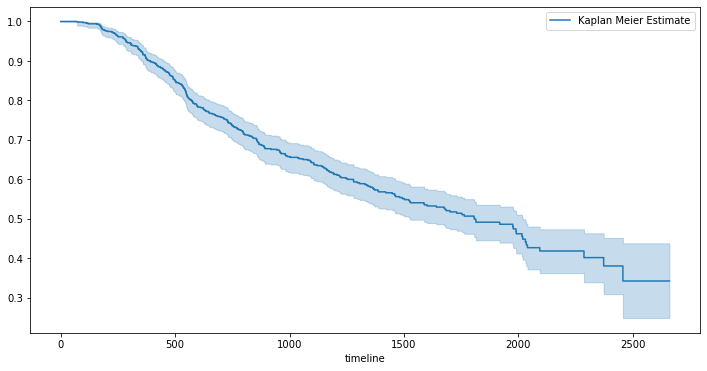

In [11]:
from lifelines import KaplanMeierFitter

durations = df['time']
event_observed = df['event']
## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

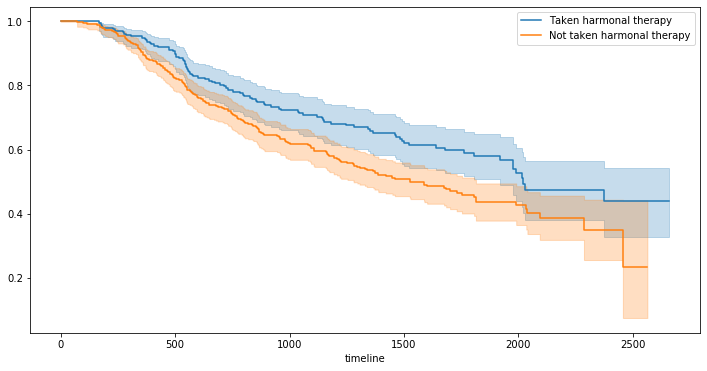

In [12]:
kmf = KaplanMeierFitter() 


T = df['time']     ## time to event
E = df['event']      ## event occurred or censored


groups = df['horTh']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'yes')   ## Cohort 1
ix2 = (groups == 'no')         ## Cohort 2


kmf.fit(T[ix1], E[ix1], label='Taken harmonal therapy')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Not taken harmonal therapy')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)

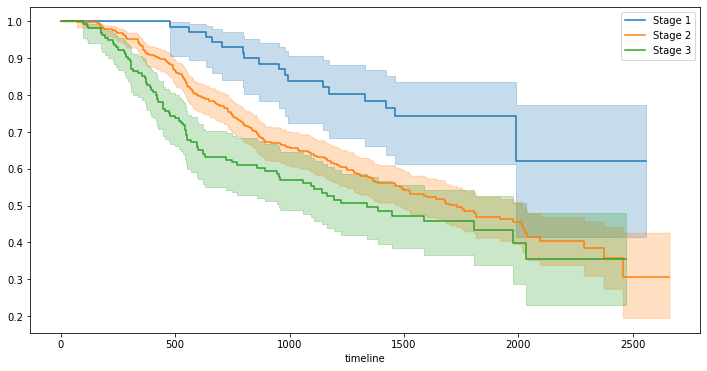

In [13]:
kmf = KaplanMeierFitter() 


T = df['time']     ## time to event
E = df['event']      ## event occurred or censored


groups = df['tgrade']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 1)   ## Cohort 1
ix2 = (groups == 2)         ## Cohort 2
ix3 = (groups == 3)         ## Cohort 3


kmf.fit(T[ix1], E[ix1], label='Stage 1')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='Stage 2')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


kmf.fit(T[ix3], E[ix3], label='Stage 3')        ## fit the cohort 3 data
kmf.plot(ax=ax1)                                 ## Plot the KM curve for three cohort on same x and y axis

In [14]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)
times = numpy.arange(365, 1826)

In [15]:
#1
rsf = RandomSurvivalForest(n_estimators=1000,min_samples_split=10,min_samples_leaf=15,max_features="sqrt",n_jobs=-1,
                           random_state=random_state).fit(X_train, y_train)
survs = rsf.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
rsf_score = integrated_brier_score(y_test, y_test, preds, times)
print(rsf_score)

0.17731976122800755


In [16]:
#2
est = CoxPHSurvivalAnalysis(ties="efron").fit(X_train, y_train)
survs = est.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
cox_ph_score = integrated_brier_score(y_test, y_test, preds, times)
print(cox_ph_score)

0.1765894001540849


In [18]:
#3
estimator = GradientBoostingSurvivalAnalysis(loss="coxph").fit(X_train, y_train)
survs = estimator.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
gbs_score = integrated_brier_score(y_test, y_test, preds, times)
print(gbs_score)

0.18742496468727118


In [20]:
#4
est = CoxnetSurvivalAnalysis(l1_ratio=0.99, fit_baseline_model=True).fit(X_train, y_train) 
survs = est.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
coxnet_score = integrated_brier_score(y_test, y_test, preds, times)
print(coxnet_score)

0.18387030486035455


In [21]:
#5
est = ExtraSurvivalTrees().fit(X_train, y_train) 
survs = est.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
est_score = integrated_brier_score(y_test, y_test, preds, times)
print(est_score)

0.1802600544625323


In [22]:
#6
est = ComponentwiseGradientBoostingSurvivalAnalysis(loss="coxph").fit(X_train, y_train) 
survs = est.predict_survival_function(X_test)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
cgbs_score = integrated_brier_score(y_test, y_test, preds, times)
print(cgbs_score)

0.18472486686898992


ZeroDivisionError: integer division or modulo by zero

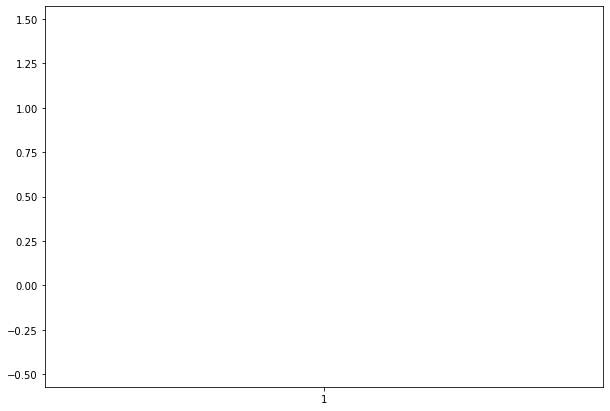

In [30]:
data = [['Random Survival Forest', 'Cox PH', 'Gradient Boosting', 'Coxnet','Extra Survival Trees','Componentwise Gradient Boosting'], [ rsf_score, cox_ph_score, gbs_score, coxnet_score, est_score, cgbs_score]]
data = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Integrated brier score (lower is better)')
plt.show()